In [1]:
%matplotlib widget

import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import *
from torchvision import datasets
from torchvision.transforms import *

In [2]:
# Download MNIST dataset
full_dataset = datasets.MNIST(
    root="data",
    download=True,
    transform=ToTensor(),
)

In [3]:
batch_size = 64

# Create data loaders.
dataloader = DataLoader(full_dataset, batch_size=batch_size)

# DELME
for X, y in dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


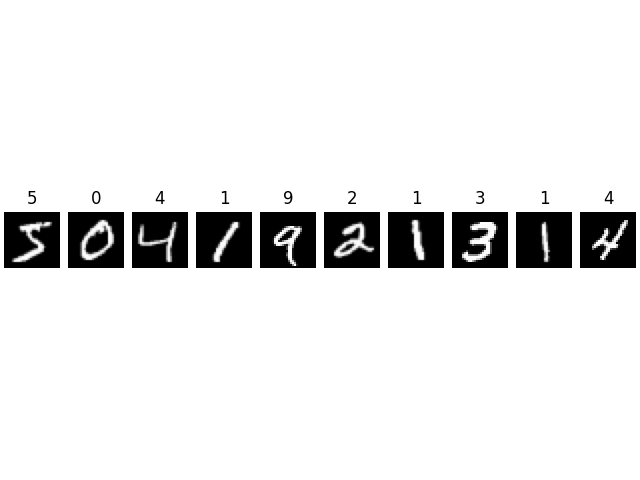

In [4]:
# Show some examples of the dataset

(fig,ax) = plt.subplots(1, 10, constrained_layout=True)
ds = full_dataset
for j in range(10):
    ax[j].imshow(ds[j][0][0], cmap="gray")
    ax[j].set_axis_off()
    ax[j].set_title(ds[j][1])
plt.show()

In [5]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using mps device


In [ ]:
# Define model
class ClassicAutoencoderMNIST(nn.Module):
    bottleneck = 10
    
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.unflatten = nn.Unflatten(1, (1,28,28))
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, self.bottleneck)
        )
        self.decoder = nn.Sequential(
            nn.Linear(self.bottleneck, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 28*28),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.flatten(x)
        coded = self.encoder(x)
        return coded

    def decode(self, x):
        x = self.decoder(x)
        decoded = self.unflatten(x)
        return decoded

    def forward(self, x):
        return self.decode( self.encode(x) )

In [6]:

class ConvAutoencoderMNIST(nn.Module):
    bottleneck = 10
    
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=2, stride=2),
            nn.Sigmoid() # Output should be in the range [0, 1]
        )

    def encode(self, x):
        coded = self.encoder(x)
        return coded

    def decode(self, x):
        decoded = self.decoder(x)
        return decoded

    def forward(self, x):
        return self.decode( self.encode(x) )

In [7]:
#model = ClassicAutoencoderMNIST().to(device)
model = ConvAutoencoderMNIST().to(device)
print(model)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

ConvAutoencoderMNIST(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
    (3): Sigmoid()
  )
)


In [8]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, X)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [9]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(dataloader, model, loss_fn, optimizer)
print("Done!")

Epoch 1
-------------------------------
loss: 0.291012  [   64/60000]
loss: 0.066249  [ 6464/60000]
loss: 0.018847  [12864/60000]
loss: 0.013177  [19264/60000]
loss: 0.008832  [25664/60000]
loss: 0.008922  [32064/60000]
loss: 0.007097  [38464/60000]
loss: 0.006920  [44864/60000]
loss: 0.006077  [51264/60000]
loss: 0.005724  [57664/60000]
Epoch 2
-------------------------------
loss: 0.005640  [   64/60000]
loss: 0.004668  [ 6464/60000]
loss: 0.004819  [12864/60000]
loss: 0.005322  [19264/60000]
loss: 0.004102  [25664/60000]
loss: 0.005051  [32064/60000]
loss: 0.004348  [38464/60000]
loss: 0.004574  [44864/60000]
loss: 0.004096  [51264/60000]
loss: 0.004056  [57664/60000]
Epoch 3
-------------------------------
loss: 0.004132  [   64/60000]
loss: 0.003575  [ 6464/60000]
loss: 0.003699  [12864/60000]
loss: 0.004291  [19264/60000]
loss: 0.003323  [25664/60000]
loss: 0.004210  [32064/60000]
loss: 0.003610  [38464/60000]
loss: 0.003983  [44864/60000]
loss: 0.003468  [51264/60000]
loss: 0.00

In [ ]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

In [ ]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth", weights_only=True))

torch.Size([1, 32, 7, 7])


TypeError: Invalid shape (1, 32, 7, 7) for image data

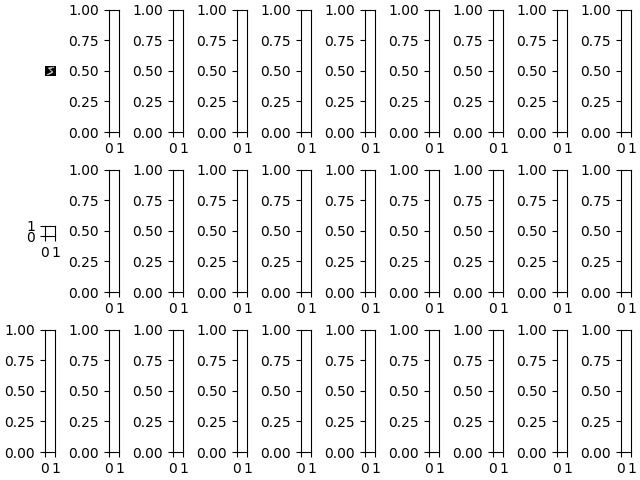

In [10]:
# Show some examples of the dataset

model.eval()
(fig,ax) = plt.subplots(3, 10, constrained_layout=True)
ds = full_dataset
for j in range(10):
    x, _ = ds[j]
    x = x[None,:].to(device)
    with torch.no_grad():
        z = model.encode(x)
        print(z.shape)
        y = model.decode(z)
    
    ax[0,j].imshow(ds[j][0][0], cmap="gray")
    ax[0,j].set_axis_off()
    ax[1,j].imshow(z[None,0].cpu(), cmap="gray")
    ax[1,j].set_axis_off()
    ax[2,j].imshow(y[0][0].cpu(), cmap="gray")
    ax[2,j].set_axis_off()
    
plt.axis('off')
plt.show()

In [ ]:
# determine mean and covariance of encoded data, and perform spectral decompositon

all_data = torch.stack([x for (x,_) in full_dataset])
all_data = all_data.to(device)

model.eval()
with torch.no_grad():
    out = model.encode(all_data)
    out = out.cpu()

u = torch.mean(out,0)
S = torch.cov(out.T)

(L,Q)=torch.linalg.eigh(S)

In [ ]:
# generate some images from random encoded data

model.eval()
(fig,ax) = plt.subplots(2, 10, constrained_layout=True)
for j in range(10):
    z = torch.randn(10)
    #z = u + torch.randn(10)
    #z = u + Q@torch.sqrt(L)*torch.randn(10)
    z = z[None,:].to(device)

    with torch.no_grad():
        y = model.decode(z)
    
    ax[0,j].imshow(z[None,0].cpu(), cmap="gray")
    ax[0,j].set_axis_off()
    ax[1,j].imshow(y[0][0].cpu(), cmap="gray")
    ax[1,j].set_axis_off()
    
plt.axis('off')
plt.show()

In [ ]:
# generate some images along 2 principal axes

model.eval()
(fig,ax) = plt.subplots(11, 11, constrained_layout=True)
for i in range(11):
    for j in range(11):
        z = u + (i-5)*torch.sqrt(L[-2])*Q[:,-2] \
              + (j-5)*torch.sqrt(L[-1])*Q[:,-1]
        z = z[None,:].to(device)
    
        with torch.no_grad():
            y = model.decode(z)
        
        ax[i,j].imshow(y[0][0].cpu(), cmap="gray")
        ax[i,j].set_axis_off()
    
plt.axis('off')
plt.show()

In [ ]:
# generate some images along the 10 highest principal values

model.eval()
(fig,ax) = plt.subplots(10, 11, constrained_layout=True)
for i in range(10):
    for j in range(11):
        z = u + (j-5)*torch.sqrt(L[-1-i])*Q[:,-1-i]
        z = z[None,:].to(device)
    
        with torch.no_grad():
            y = model.decode(z)
        
        ax[i,j].imshow(y[0][0].cpu(), cmap="gray")
        ax[i,j].set_axis_off()
    
plt.axis('off')
plt.show()